In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

# seaborn darkstyle
sns.set_style("darkgrid")

# Gaussian Processes

Take the exponential quadratic kernel: 
- the further away two points, the smaller the kernel value (tends to 0).
- the closer two points: the kernel value tends to 1.

Create a covariance matrix: each column represents one point on the x axis. The further away 2 columns, the smaller the covariance between the 2 columns

In [2]:
def exp_quad_kernel(x, knots, width=1):
    """exponentiated quadratic kernel"""
    return np.array([np.exp(-(x-k)**2 / (2*width**2)) for k in knots])

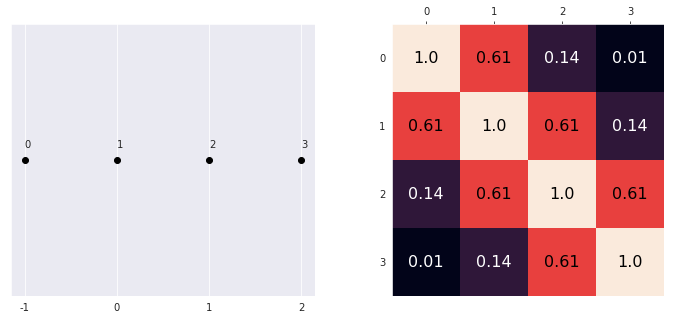

In [18]:
# This cell is from the excellent book: 
# Bayesian Analysis with Python - Second Edition by Osvaldo Martin

data = np.array([-1, 0, 1, 2])  # np.random.normal(size=4)
cov = exp_quad_kernel(data, data, 1)

_, ax = plt.subplots(1, 2, figsize=(12, 5))
ax = np.ravel(ax)

ax[0].plot(data, np.zeros_like(data), 'ko')
ax[0].set_yticks([])
for idx, i in enumerate(data):
    ax[0].text(i, 0+0.005, idx)
ax[0].set_xticks(data)
ax[0].set_xticklabels(np.round(data, 2))

ax[1].grid(False)
im = ax[1].imshow(cov)
colors = ['w', 'k']
for i in range(len(cov)):
    for j in range(len(cov)):
        ax[1].text(j, i, round(cov[i, j], 2),
                   color=colors[int(im.norm(cov[i, j]) > 0.5)],
                   ha='center', va='center', fontdict={'size': 16})
ax[1].set_xticks(range(len(data)))
ax[1].set_yticks(range(len(data)))
ax[1].xaxis.tick_top()

Now take a much bigger number of points (e.g. 200). We obtain a 200x200 covariance matrix. And use this as a multivariate normal distribution with means = 0. Take samples from it: by definition of the covariance matrix:
- two close x will have a covariance close to 1, thus will vary in the same way, hence will have a close value.
- two x that are far away will have a much smaller covariance: their value can be very different.

About the width:
- The larger the width (used in the kernel function), then two points will have a more similar value.  
- The smaller the width, the more will allow differences between the two points.

For example:

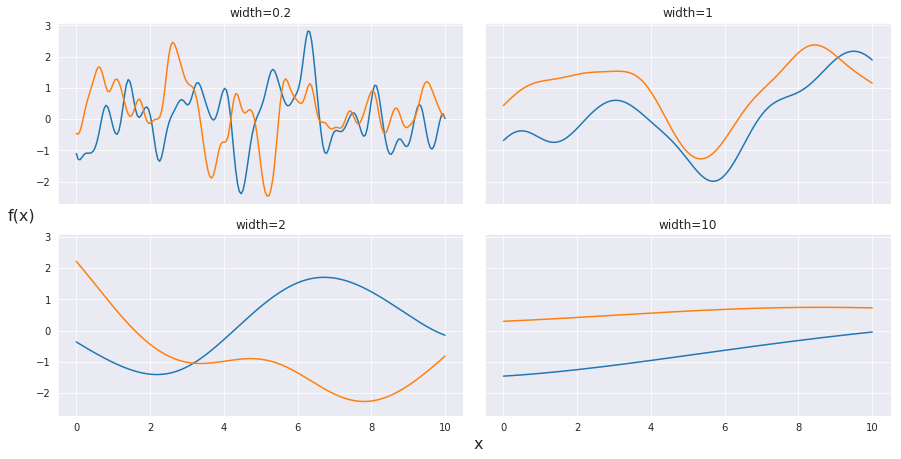

In [4]:
# This cell is from the excellent book: 
# Bayesian Analysis with Python - Second Edition by Osvaldo Martin

np.random.seed(23)
test_points = np.linspace(0, 10, 200)
fig, ax = plt.subplots(2, 2, figsize=(12, 6), sharex=True,
                       sharey=True, constrained_layout=True)
ax = np.ravel(ax)

for idx, width in enumerate((0.2, 1, 2, 10)):
    cov = exp_quad_kernel(test_points, test_points, width)
    ax[idx].plot(test_points, stats.multivariate_normal.rvs(cov=cov, size=2).T)
    ax[idx].set_title(f'width={width}')
fig.text(0.51, -0.03, 'x', fontsize=16)
fig.text(-0.03, 0.5, 'f(x)', fontsize=16);

# What are the possible values of some points given other points given by the data ?

Create a covariance matrix made of 100 points, evenly spaced between x=0 and x=10. Use width=1.

In [5]:
num_points = 100
x = np.linspace(0, 10, num_points)
np.set_printoptions(suppress=True)
width=1
cov = exp_quad_kernel(x, x, width)
print(cov)

[[1.         0.99491147 0.97980071 ... 0.         0.         0.        ]
 [0.99491147 1.         0.99491147 ... 0.         0.         0.        ]
 [0.97980071 0.99491147 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.99491147 0.97980071]
 [0.         0.         0.         ... 0.99491147 1.         0.99491147]
 [0.         0.         0.         ... 0.97980071 0.99491147 1.        ]]


Let's set a few points for 3 x values:
- x=2 -> y=2
- x=5 -> y=2
- x=8 -> y=-1

We force the values of these 3 points. What are the possible values of other points ?  
Remember how the covariance matrix was built with the kernel:
- a x close to 2 will have its y close to 2.
- the further from x=2, the more we allow y to be far from 2

We have our covariance matrix with 100 columns, 100 rows (for 100 values of x from 0 to 10) and we set the values for x = 2, 5 and 8, thus corresponding to indices 20, 50 and 80



In [6]:
data_x = np.array([2.0, 5, 8])
data_y = np.array([2.0, 2.0, -1])

# find the indices of data_x
data_x_indices = ((data_x - x.min())/(x.max()-x.min()) * num_points).astype(np.int)
data_x_indices

array([20, 50, 80])

We need to determine the multivariate distribution of the 97 other x that are not set **given** those 3 x that we've set.  
The formula for this is given here:

https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions

Another great tutorial that gives this formula is:  
http://videolectures.net/epsrcws08_rasmussen_lgp

So assume the joint distribution $p(x,y)$ (x being the 97 unknown points and y the 3 set points) is given by this:

$p(x,y) \sim \mathcal{N}(
 \begin{pmatrix}
   a  \\
   b 
 \end{pmatrix} 
 , 
 \begin{pmatrix}
   A & B \\
   B^T & C 
 \end{pmatrix}
 )
 $

- a is the vector of the 97 means of the unknown points
- b is the vector of the 3 means of the forced points

Let's force a and b to 0. We also have:  
- A is a 97x97 block matrix for the covariance of the unknown points
- B is a 3x3 block matrix for the covariance of the forced points

Then:
 
$p(x|y) \sim \mathcal{N}(a+BC^{-1}(y-b), A-BC^{-1}B^T) $

Let's get A,B,C from the covariance matrix and calculate the distribution for the 97 unknown points given the 3 forced points. This will be:
- a vector of 97 values for the 97 means
- a 97x97 covariance matrix

In [7]:
bool_indices = np.zeros(num_points, dtype=bool)
bool_indices[data_x_indices] = True
# 3 values are True, the 97 others are False
print(bool_indices)

# get A,B,C
A = cov[:,~bool_indices][~bool_indices,:]
C = cov[:,bool_indices][bool_indices,:]
B = cov[~bool_indices,:][:,bool_indices]
print()
print('A.shape: %s' % str(A.shape))
print('B.shape: %s' % str(B.shape))
print('C.shape: %s' % str(C.shape))

[False False False False False False False False False False False False
 False False False False False False False False  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False  True False False False
 False False False False False False False False False False False False
 False False False False]

A.shape: (97, 97)
B.shape: (97, 3)
C.shape: (3, 3)


In [8]:
# calculate the 97 means for p(x|y):
rem_mu = np.matmul( np.matmul(B, np.linalg.inv(C)), data_y[:,np.newaxis] )
rem_mu.reshape(1,-1)[0]

array([ 0.25728279,  0.31392156,  0.37914179,  0.45326559,  0.53638301,
        0.6283032 ,  0.72851188,  0.83613931,  0.94994253,  1.0683056 ,
        1.18926042,  1.31052968,  1.42959226,  1.54376945,  1.65032887,
        1.74660147,  1.83010531,  1.8986693 ,  1.95054929,  1.98452913,
        1.99701249,  1.97629766,  1.93925501,  1.88790769,  1.82482694,
        1.75302976,  1.6758552 ,  1.59682561,  1.51949975,  1.44732485,
        1.38349412,  1.33081585,  1.29159935,  1.26756175,  1.25975912,
        1.268544  ,  1.29355079,  1.33370933,  1.38728627,  1.4519529 ,
        1.52487708,  1.60283601,  1.68234563,  1.75980132,  1.83162387,
        1.89440396,  1.94503824,  1.98085   ,  1.99968828,  1.98087167,
        1.94203858,  1.88386196,  1.80727635,  1.71371173,  1.60499635,
        1.48324748,  1.35075809,  1.20988693,  1.06295941,  0.91218485,
        0.7595943 ,  0.60700121,  0.4559848 ,  0.30789459,  0.16387232,
        0.0248866 , -0.10822527, -0.23471405, -0.35387938, -0.46

In [9]:
# calculate the 97x97 covariance matrix for p(x|y)
rem_cov = A -  np.matmul( np.matmul(B, np.linalg.inv(C)), B.T )
rem_cov.shape

(97, 97)

Now for each i-th point of the 97 unknown points, $cov[i,i]$ gives the standard deviation.  
So for each of those points, calculate the mean and the upper/lower bounds that are respectively +2 and -2 standard deviations around the mean

In [11]:
means=[]
upper=[]
lower=[]
for i in range(len(rem_mu)):
    mu = rem_mu[i][0]
    means.append(mu)
    sigma = rem_cov[i,i]
    upper.append(mu + 2*sigma)
    lower.append(mu - 2*sigma)

In [12]:
# create the 97 indices (100 minus the 3 indices for the 3 known points: 20, 30 and 80)
rem_indices=np.arange(num_points)[~bool_indices]
rem_indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87,
       88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [15]:
# so data_x_indices will be the indices of the known points, and the values for those points 
# are data_y

# rem_indices are the remaining indices for the 97 other points and the values are given by 
# the means and upper+lower bounds

# So we can construct 3 arrays of 100 points for the means, upper and lower bounds:

all_means = np.zeros(num_points)
all_means[data_x_indices] = data_y
all_means[rem_indices] = np.array(means)

all_upper = np.zeros(num_points)
all_upper[data_x_indices] = np.array(data_y)
all_upper[rem_indices] = np.array(upper)

all_lower = np.zeros(num_points)
all_lower[data_x_indices] = np.array(data_y)
all_lower[rem_indices] = np.array(lower)


The 3 curves go through the 3 known points and the further away from those 3 points, the more the 97 other points can vary

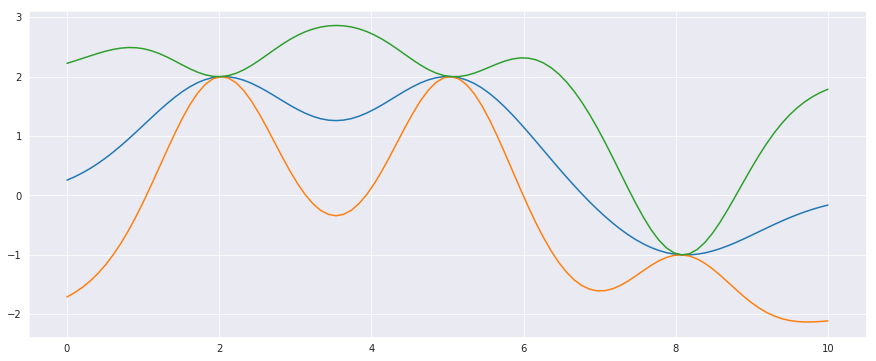

In [16]:
plt.figure(figsize=(15,6))
plt.plot(x, all_means)
plt.plot(x, all_lower)
plt.plot(x, all_upper);

Retry this notebook with other widths: a larger width will reduce the variability between known points.  
Try also other kernel functions